<a href="https://colab.research.google.com/github/tom5610/ai-ml-workshop/blob/main/cv/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-j9al1qnn
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-j9al1qnn
  Created wheel for tensorflow-examples: filename=tensorflow_examples-f9dfe1d72d3a2e4ae9673eddf0e416c3c6ddaeaf_-py3-none-any.whl size=271411 sha256=64adc590eb602304a13cb14daf52850db723914fa261f0cd0c5b91667c19c9ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-1fvt6oj_/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds 

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix 

from IPython.display import clear_output 
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2I4YT1/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2I4YT1/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [12]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    print(input_image.shape)
    print(input_mask.shape)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [7]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [14]:
train_images = dataset['train'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)

(128, 128, 3)
(128, 128, 1)
(128, 128, 3)
(128, 128, 1)


In [16]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed = 42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes
        self.augment_inputs = preprocessing.RandomFlip(mode = 'horizontal', seed = seed)
        self.augment_labels = preprocessing.RandomFlip(mode = 'horizontal', seed = seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [19]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size = tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [20]:
type(train_images)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [21]:
def display(display_list):
    plt.figure(figsize = (15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

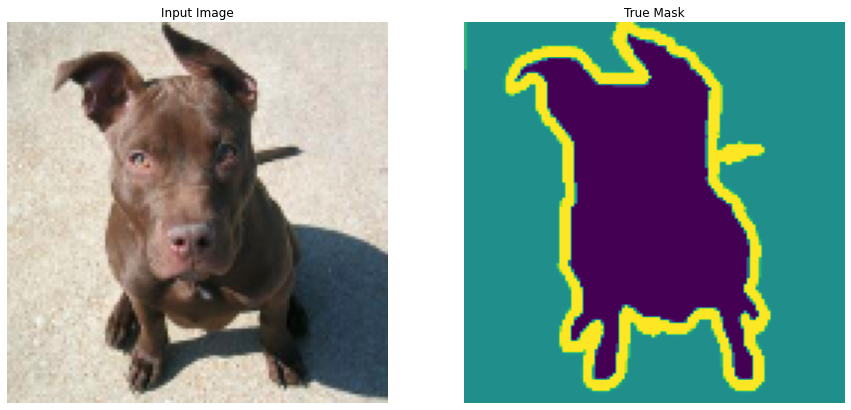

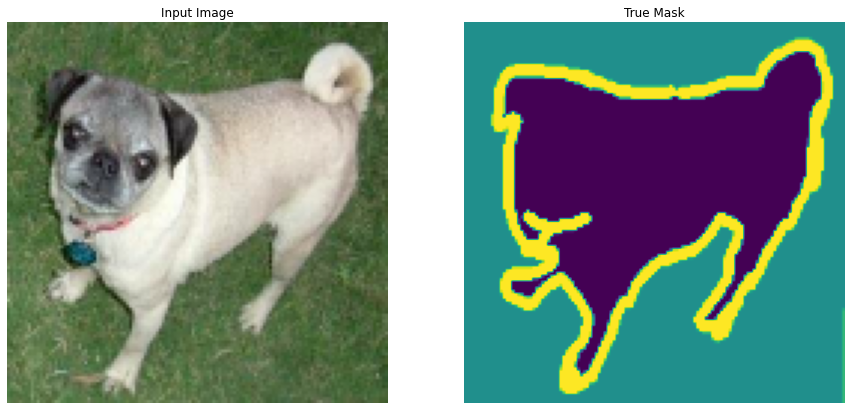

In [22]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])